In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix , classification_report

In [2]:
#Initialized two list X , Y
# X stores all the document names and document words (the words in them)
# Y stores the categories of all the documents
X = [] 
Y = []
#loading files from directory where catg is the category of the file
for catg in os.listdir('20_newsgroups'):
    #loading docs in the folder or list of directories
    for doc in os.listdir('20_newsgroups/' + catg):
        #opened the document as a file and reading from it
        with open('20_newsgroups/' + catg + '/' + doc) as file:
            #appening file words to x and category to y
            X.append((doc , file.read()))
            Y.append(catg)

In [3]:
#splitting data into training and testing
X_train , X_test , Y_train , Y_test = train_test_split(X , Y)

In [4]:
#loading a list of stopwords from ntlk library for NLP
from nltk.corpus import stopwords
stopwords = stopwords.words("english")
#added I as it gave a good improvement in score
stopwords.append('I')

In [5]:
# loading all words to a dictionary named vocabulary mapped to their respective frequencies
vocabulary = {}
for i in range(len(X_train)):
    #all the words are stored in 1th(indexwise) column of X as the 0th one conatins the name of doc
    for word in X_train[i][1].strip().split():
        new_word = word.lower()
        #creating a vocabulary , adding a word if not present , and if present, incrementing freq by 1
        if word not in stopwords: #add only if not a stopword
            if word in vocabulary:
                vocabulary[word] += 1
            else:
                vocabulary[word] = 1
len(vocabulary)

324785

Text(0.5,1,'Graph of words vs frequency')

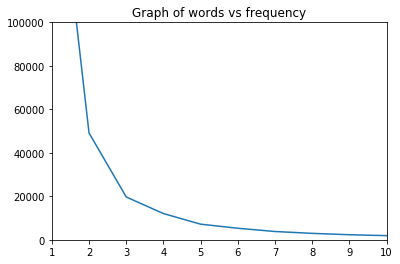

In [6]:
size = max(vocabulary.values()) + 1
l = [0 for i in range(size)]
#adding number of words at an index with their freq equal to tht particular index
for keys in vocabulary.keys():
    l[vocabulary[keys]] += 1
#determining the frequecy of all words
frequency = [i for i in range(max(vocabulary.values())+1)] 
#plotted graph for freq of words and num of words to determine cutoff frequency
plt.plot(frequency , l)
plt.axis([1, 10 , 0 ,100000])
plt.title('Graph of words vs frequency')

In [7]:
#determining num of words above cutoff
#there are decently many words with above 100 frequency , and many redundant words are thus removed
cutoff = 100
words_above_cutoff  = len(vocabulary) - sum(l[0:100])
print('words above the cutoff are :' , words_above_cutoff)

words above the cutoff are : 2727


In [8]:
#appending final words that we want to use as features based on frequency onto a dictionary
final_features = []
for key in vocabulary.keys():
    #we append words with frequency greater than 100 onto the final_features list
    if vocabulary[key] >= 100:
        final_features.append(key)

In [9]:
# creating a dataframe of training dataset with chosen words as features
# adding the frequncy of a word
final_train_dataset = np.zeros((len(X_train) , len(final_features)))
for i in range(len(X_train)):
    list_of_words = [ word.strip() for word in X_train[i][1].split()]
    for word in list_of_words:
        if word in final_features:
            final_train_dataset[i][final_features.index(word)] += 1

In [10]:
# creating a dataframe of testing dataset with chosen words as features
# adding the frequncy of a word
final_test_dataset = np.zeros((len(X_test) , len(final_features)))
for i in range(len(X_test)):
    list_of_words = [ word.strip() for word in X_test[i][1].split()]
    for word in list_of_words:
        if word in final_features:
            final_test_dataset[i][final_features.index(word)] += 1

In [11]:
# applying inbuilt algorithm to determine score

from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(final_train_dataset , Y_train)
Y_pred = clf.predict(final_test_dataset)
print(classification_report(Y_pred , Y_test))
print((confusion_matrix(Y_pred , Y_test)))
print('Score using sklearn NB classifier' , clf.score(final_test_dataset , Y_test))

                          precision    recall  f1-score   support

             alt.atheism       0.93      0.91      0.92       273
           comp.graphics       0.72      0.78      0.75       240
 comp.os.ms-windows.misc       0.82      0.84      0.83       260
comp.sys.ibm.pc.hardware       0.84      0.83      0.83       241
   comp.sys.mac.hardware       0.89      0.84      0.86       280
          comp.windows.x       0.80      0.90      0.85       222
            misc.forsale       0.86      0.72      0.78       309
               rec.autos       0.94      0.84      0.89       265
         rec.motorcycles       0.92      0.87      0.90       272
      rec.sport.baseball       0.91      0.82      0.86       260
        rec.sport.hockey       0.76      0.96      0.85       198
               sci.crypt       0.87      0.95      0.91       218
         sci.electronics       0.82      0.75      0.79       252
                 sci.med       0.85      0.94      0.89       229
         

In [12]:
#Fitting the data and creating the dictionary to calculate probability
#the dictionary has 2 levels : the first one conatins classes as keys
# the second level contains document names
#it has total as a key meaning total datapoints
def fit(x , y):   
        res = {}
        classes = set(y)
        for cls in classes:
            res[cls] = {}
            for i in range(len(x[0])):
                res[cls][i] = 0
            res[cls]['total'] = 0
        res['total_points'] = len(x)
        
        for i in range(len(x)):
            for j in range(len(x[0])):
                res[y[i]][j] += x[i][j] #freq of words in a particular class
            res[y[i]]['total'] += 1   
        return res

In [13]:
# calculating log probability
def probability(res , x , class_value):
        log_prob = np.log(res[class_value]['total']) - np.log(res['total_points'])
        total_words = len(x)
        for i in range(len(x)):
            #implementing the laplace correction
            current_word_prob = x[i]*(np.log(res[class_value][i]+1)-np.log(res[class_value]['total']+total_words))
            log_prob += current_word_prob
        return log_prob

In [14]:
# predicting for a single point in data
def predict_one_point(res , x):
    best_probability = None
    best_class = None
    classes = res.keys()
    run = True
    for cls in classes:
        if cls == 'total_points':
            continue
        prob = probability(res , x , cls)
        if run or best_probability < prob :
            best_probability = prob
            best_class = cls
        run = False
    return best_class

In [15]:
# predict function : returns a list with the predictions
def predict(res , x):
    y_pred = []
    for test in x:
        y_pred.append(predict_one_point(res , test))
    return y_pred

In [16]:
# calculating score to determine how accurate we are
def score(y_pred , y):
    cnt = 0
    for i in range(len(y)):
        if y_pred[i] == y[i]:
            cnt = cnt + 1
    return cnt/len(y)

In [17]:
#dictionary obtained after fitting the data
res = fit(final_train_dataset , Y_train)

In [18]:
Y_test_pred = predict(res , final_test_dataset)

In [19]:
#printing and determining accuracy through various metrics available in sklearn
print(classification_report(Y_test_pred , Y_test))
print((confusion_matrix(Y_test_pred , Y_test)))
print('Score using our classifier : ' , score(Y_test_pred , Y_test))

                          precision    recall  f1-score   support

             alt.atheism       0.93      0.67      0.78       368
           comp.graphics       0.76      0.59      0.66       338
 comp.os.ms-windows.misc       0.54      0.94      0.69       153
comp.sys.ibm.pc.hardware       0.71      0.77      0.74       217
   comp.sys.mac.hardware       0.55      0.99      0.71       145
          comp.windows.x       0.89      0.77      0.82       288
            misc.forsale       0.43      0.97      0.60       114
               rec.autos       0.76      0.91      0.83       195
         rec.motorcycles       0.56      0.98      0.71       146
      rec.sport.baseball       0.80      0.97      0.88       194
        rec.sport.hockey       0.96      0.80      0.87       299
               sci.crypt       0.98      0.32      0.48       733
         sci.electronics       0.42      0.93      0.58       104
                 sci.med       0.82      0.83      0.83       247
         

C:\Users\NILESH\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
